<a href="https://colab.research.google.com/github/benrandoing20/Sketch2CAD/blob/main/VGGSketch2CAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
# Mounts Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Navigate to appropriate directory with Dataset as starting point
!pwd
%cd drive/Shareddrives/CS231:Sketch2CAD/CS231N:FinalProject/Data

/content
/content/drive/Shareddrives/CS231:Sketch2CAD/CS231N:FinalProject/Data


# Import Packages

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import ast
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
#     device = torch.device('cpu')

# Load Data and Pre-Process IMG

In [ ]:
DATA_DIR = '/content/drive/Shareddrives/CS231:Sketch2CAD/CS231N:FinalProject/Data/'
metadata_filename = 'my_dict.csv'

# read in csv into pd DataFrame
df_train = pd.read_csv(metadata_filename)
print(df_train.head())

# count the total number of data samples
n_datasample = len(df_train)
print("Number of training samples:", n_datasample)

# obtain image file from filename associated with row and cache label


         Name                                                Rep
0  '00000007'  [[4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
1  '00000061'  [[4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
2  '00000070'  [[4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
3  '00000073'  [[4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
4  '00000093'  [[4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
Number of training samples: 14724


# TODO: Train / Valid / Test Split

In [ ]:
test_data = df_train[:1000].reset_index(drop=True)
val_data = df_train[1000:2000].reset_index(drop=True)
train_data = df_train[2000:].reset_index(drop=True)

# Define Dataset Class


In [ ]:
IMG_DIR = '/content/drive/Shareddrives/CS231:Sketch2CAD/CS231N:FinalProject/Data/pics/'

#TODO: Get ground truth labels from DeepCAD outputa
class sketchDataset(Dataset):
    # Takes a pandas dataframe input of image filenames under 'Name' and labels under 'Rep'
    def __init__(self, df):
        self.X = df['Name']
        self.y = df['Rep']
        # transform normalizes and prepares image for pretraind VGG network (
        # norm µ and sigma from data used for VGG training)
        self.transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Lambda(lambda tensor: torch.abs(tensor - 1)),
            # T.Normalize(mean=np.mean([0.485, 0.456, 0.406]), std=np.mean([0.229, 0.224, 0.225]))
        ])

    def __len__(self):
        # Denotes the total number of samples
        return len(self.X)

    def __getitem__(self, index):
        # Generates one sample of data
        imageFileName = self.X[index]
        label = ast.literal_eval(self.y[index])
        pad_token = [3] + 16 * [-1]
        label_pad = label + (60 - len(label)) * [pad_token]
        y_label = torch.tensor(label_pad)

        label_pad_type = torch.nn.functional.one_hot(y_label[:, 0], num_classes=6)
        # print(label_pad_type)
        
        label_pad_param = torch.nn.functional.one_hot(y_label[:, 1:] + 1, num_classes=257)
        # print(label_pad_param.size())
        
        # print(imageFileName)
        image = Image.open(IMG_DIR + imageFileName[1:-1] + '.png')
        image = image.convert('RGB')
        plt.imshow(image) # check to ensure image is loaded
        plt.show()
        image = self.transform(image)
        return image, label_pad_type, label_pad_param

traindata = sketchDataset(train_data)
testdata = sketchDataset(test_data)
valdata = sketchDataset(val_data)
# print(data[1])

# Define DataLoader

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8512aa92d0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8512aa92d0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

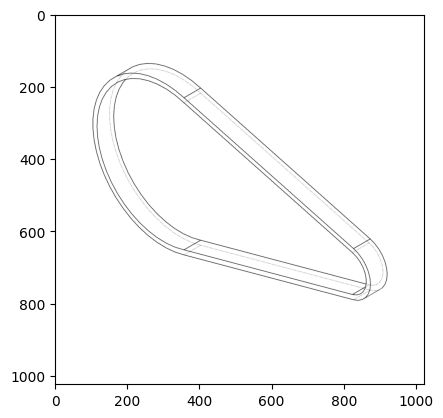

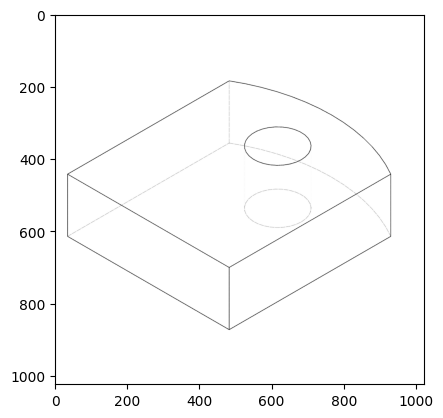

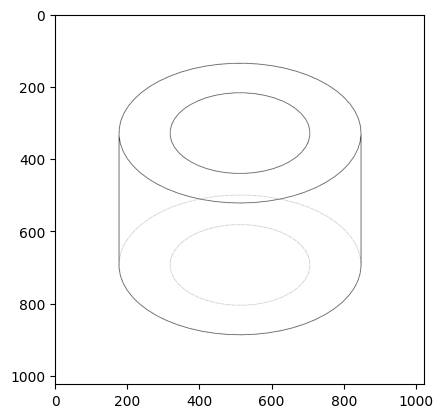

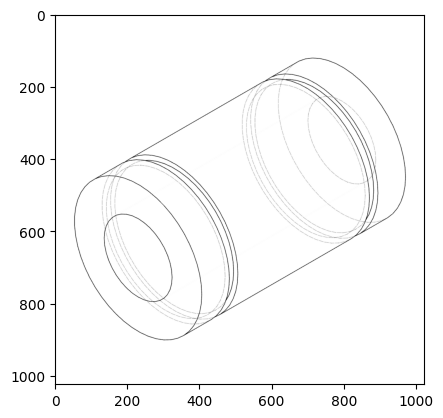

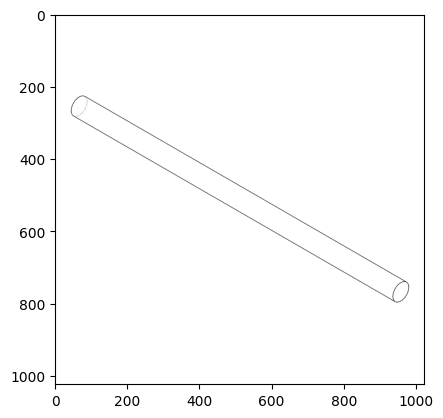

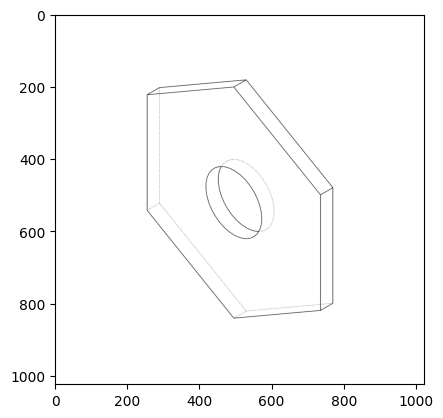

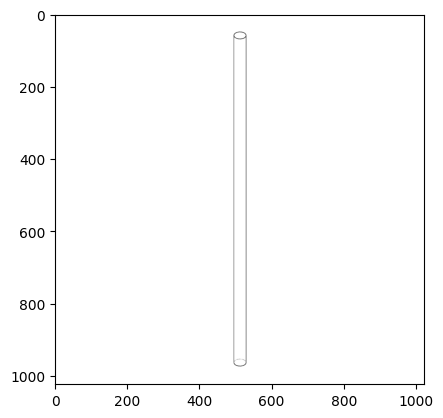

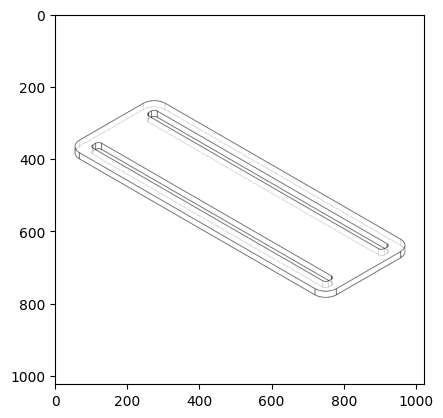

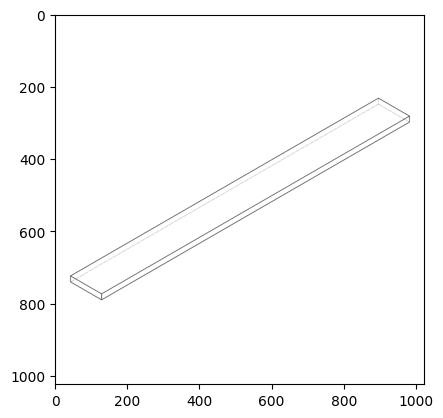

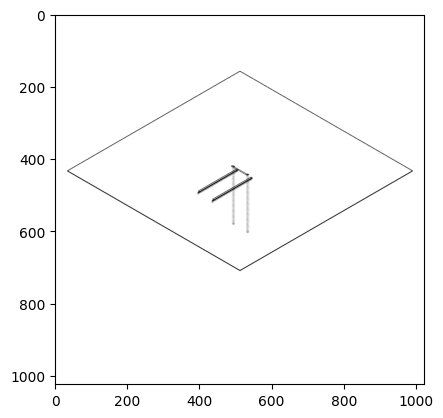

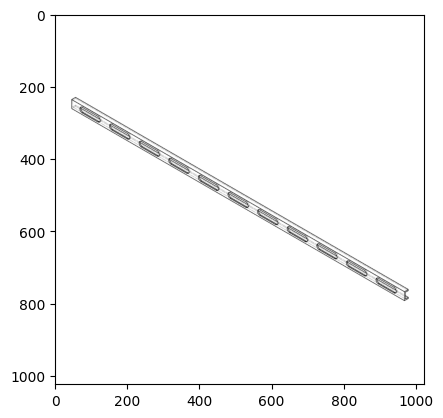

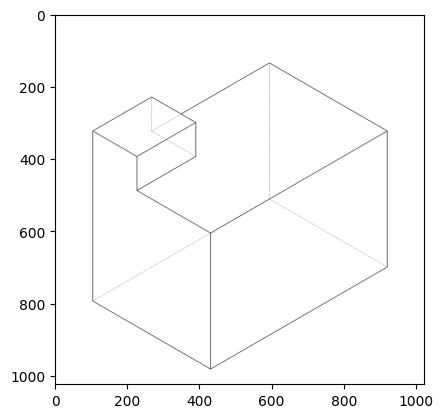

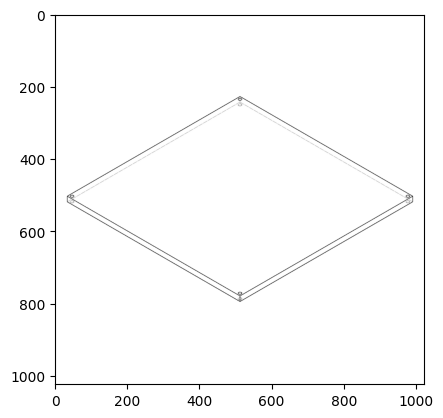

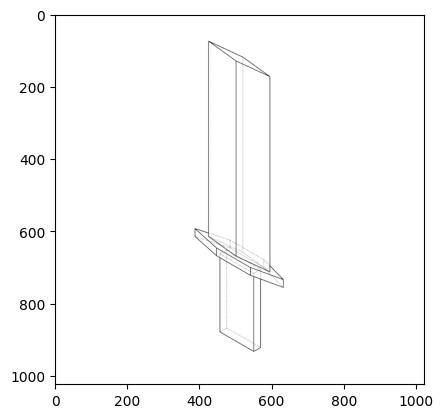

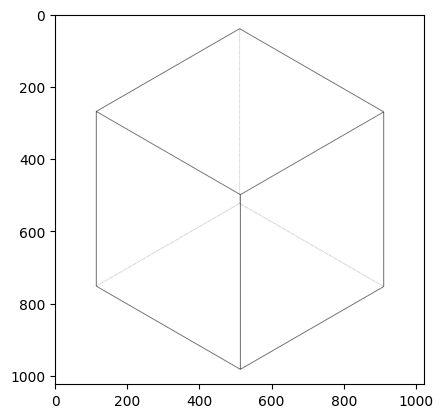

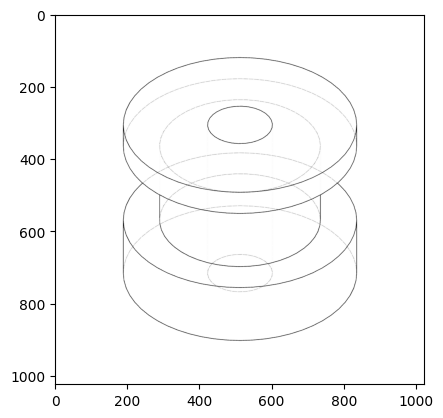

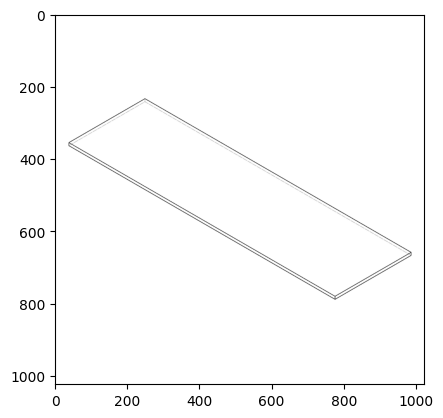

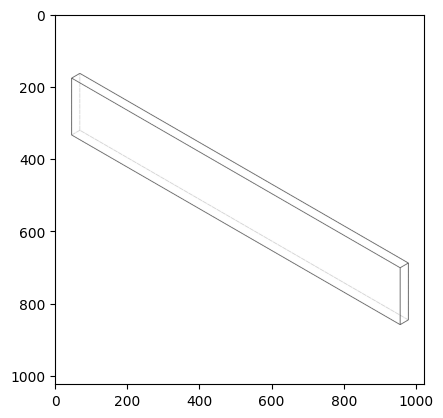

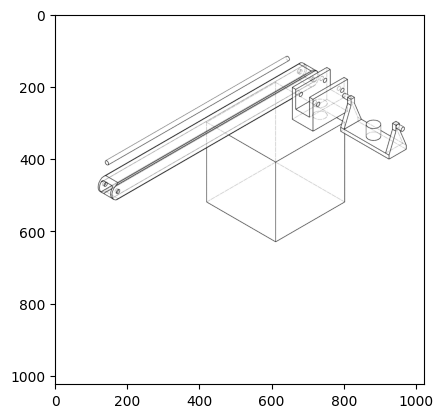

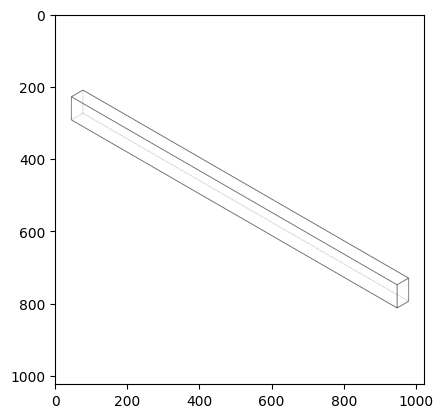

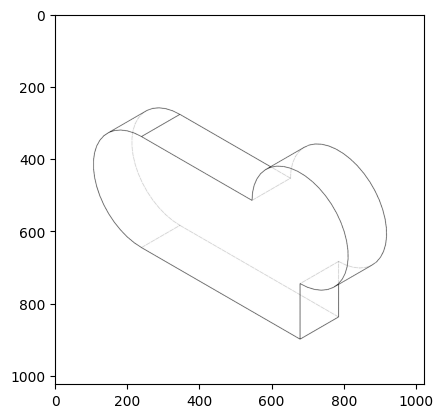

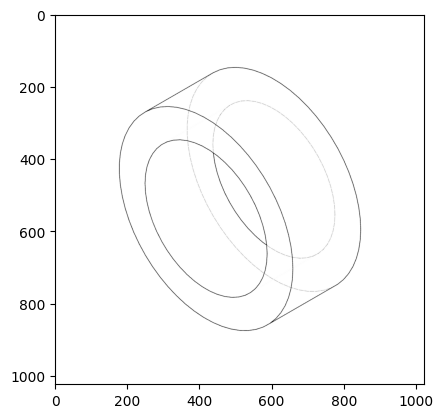

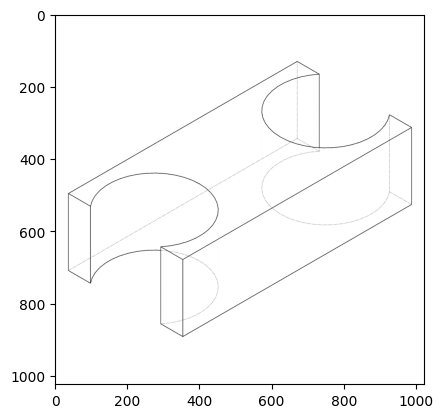

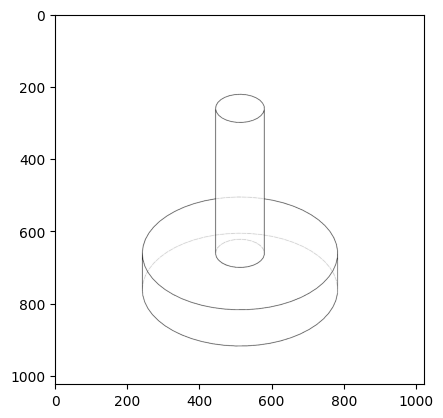

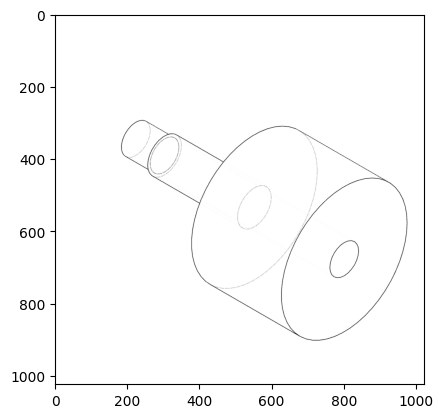

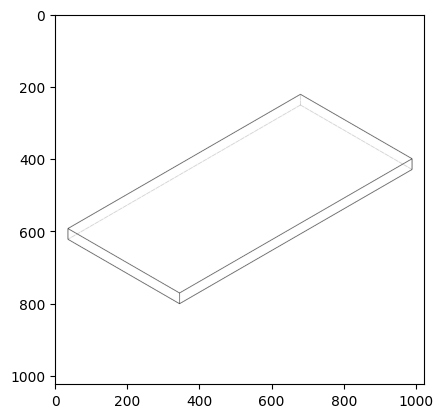

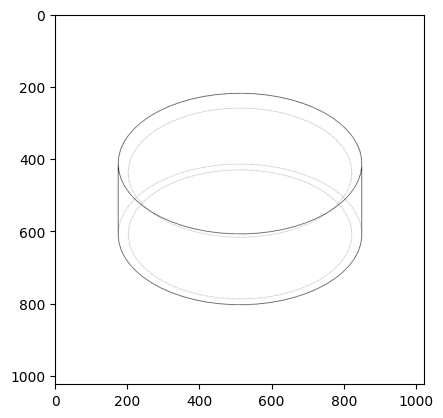

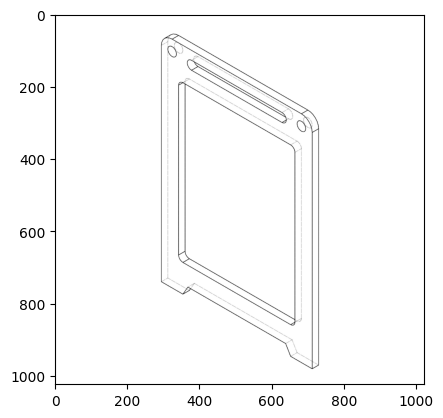

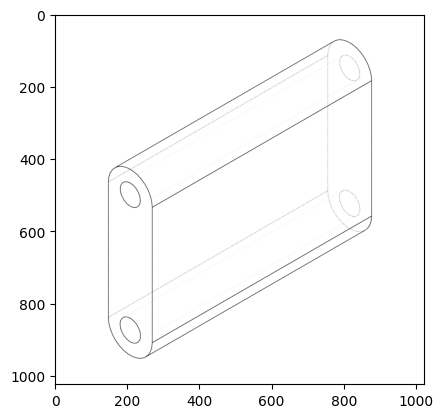

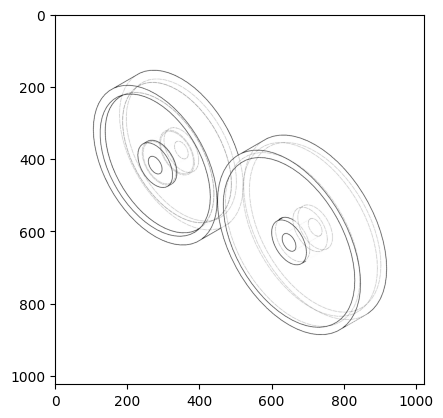

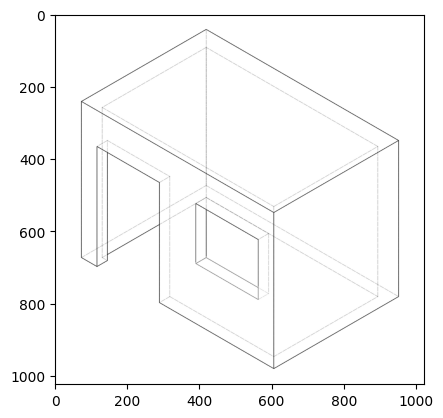

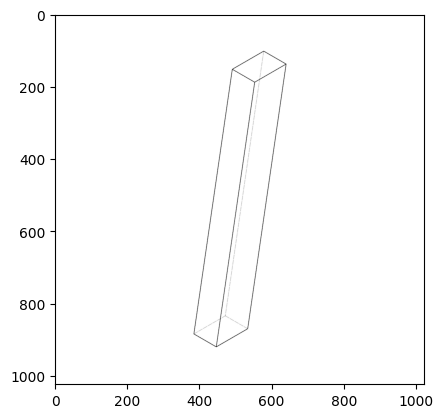

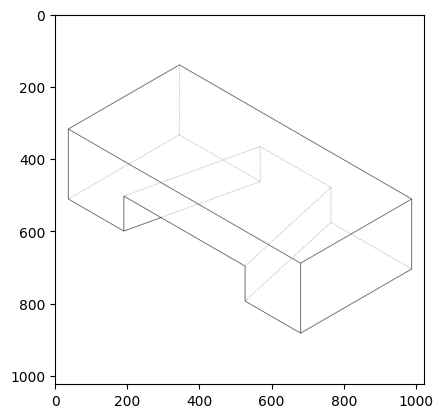

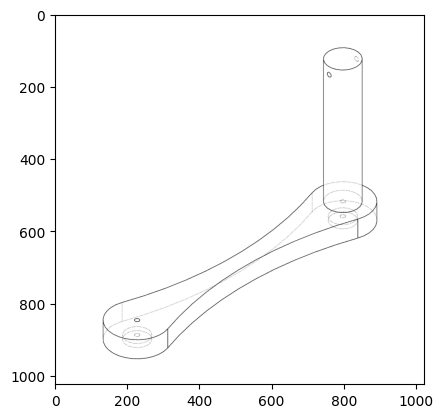

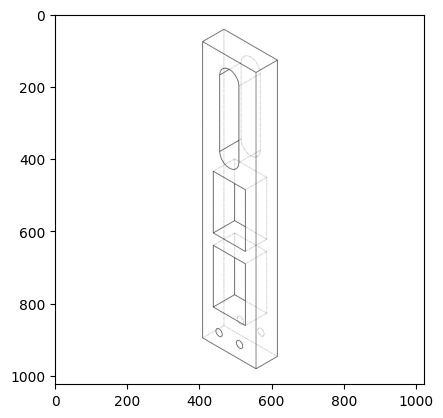

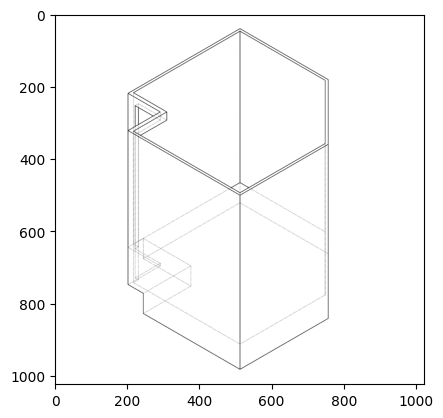

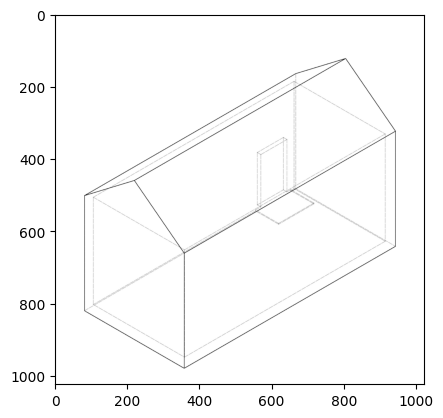

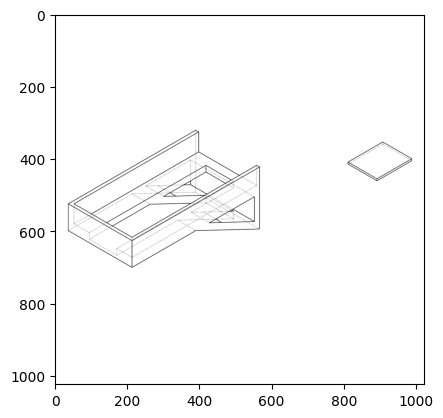

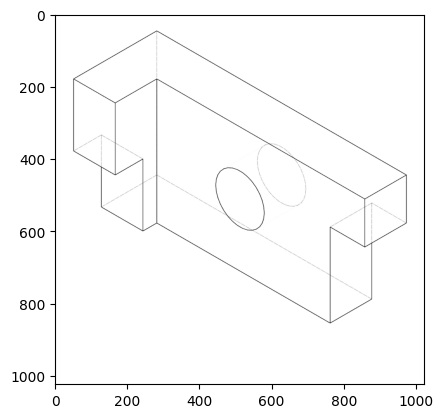

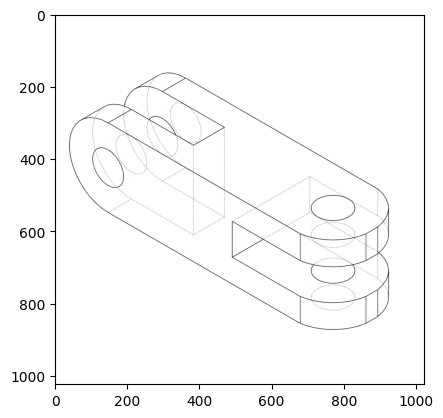

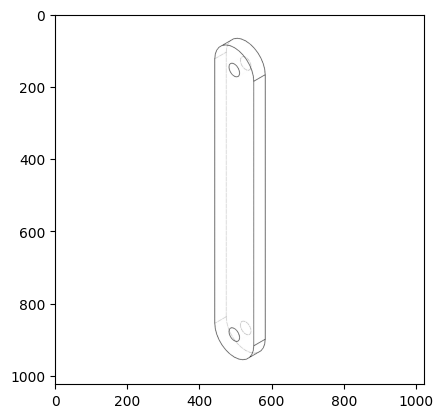

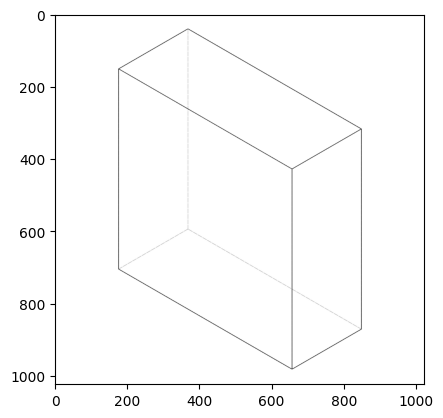

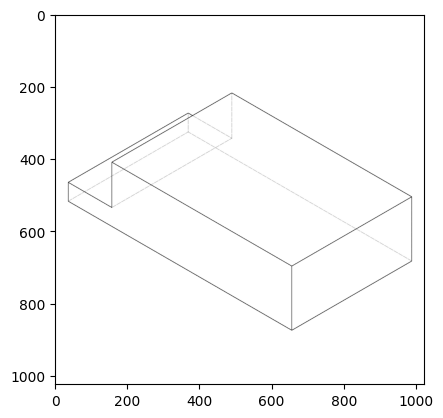

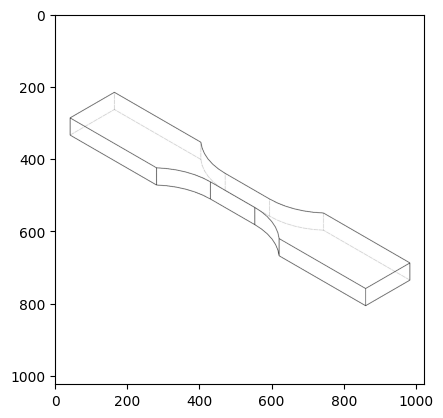

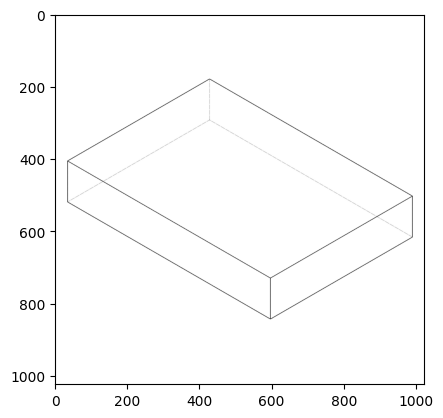

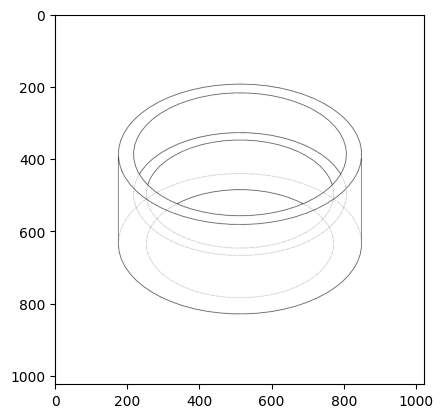

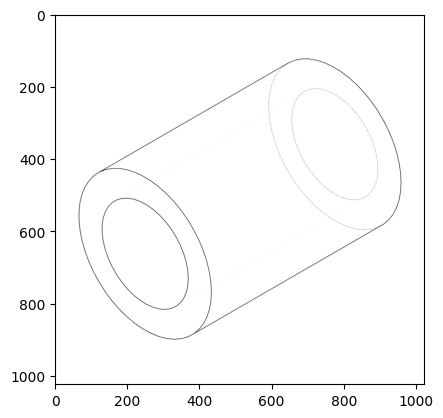

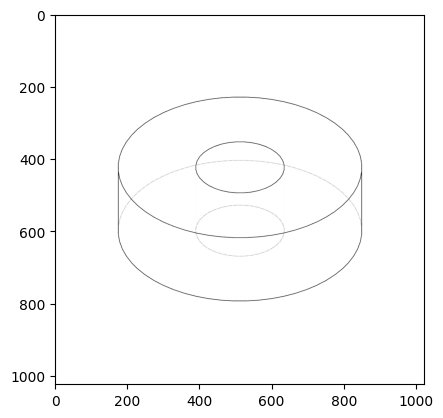

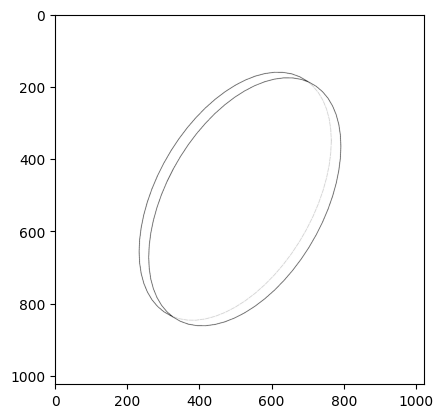

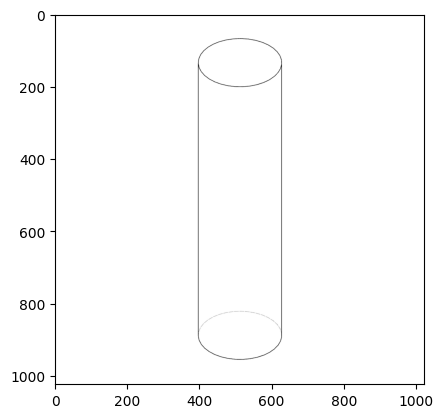

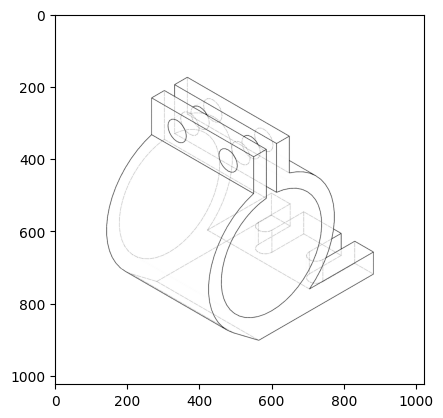

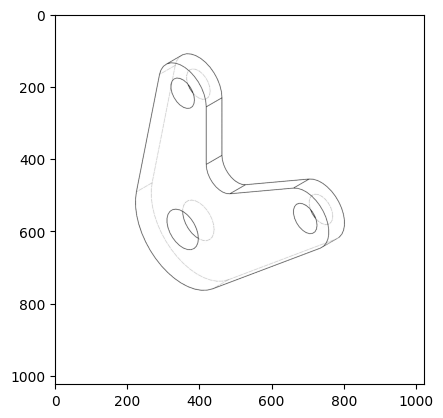

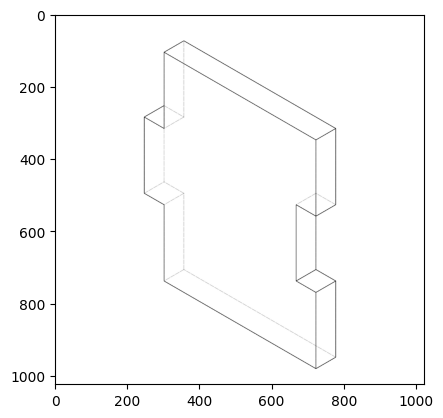

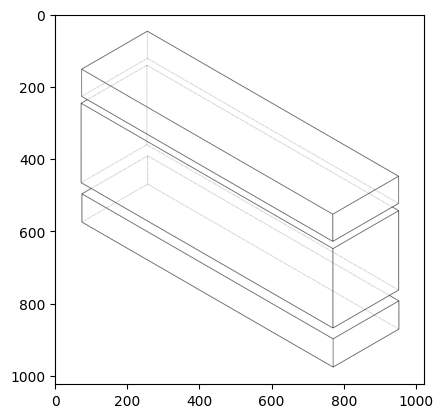

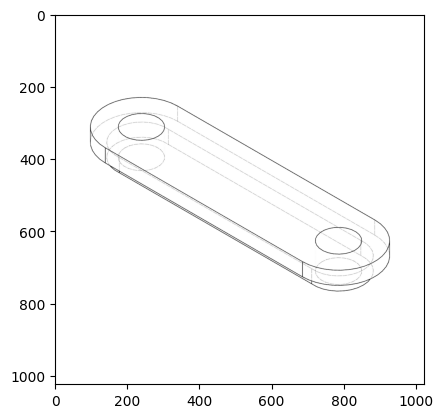

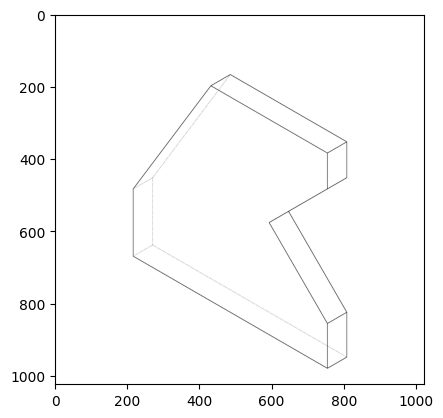

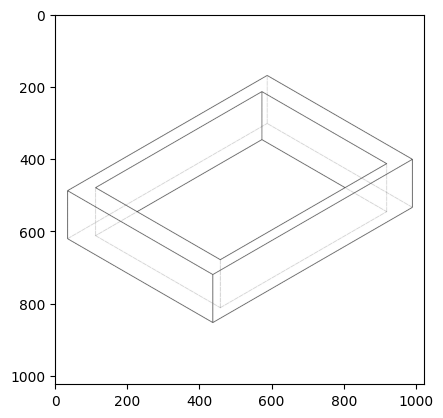

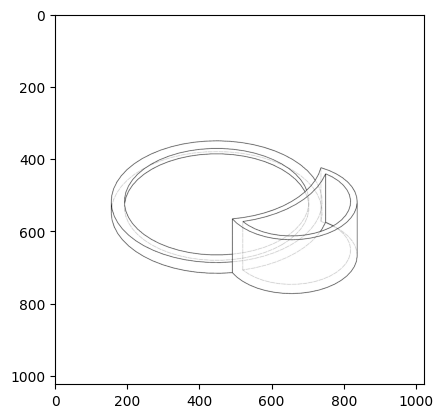

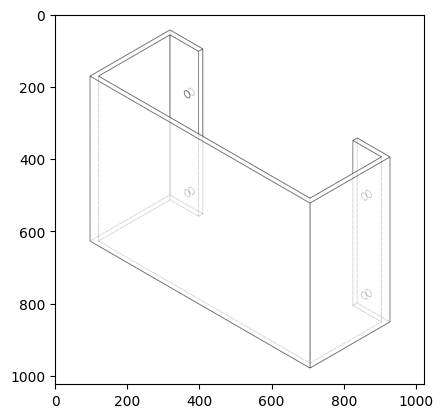

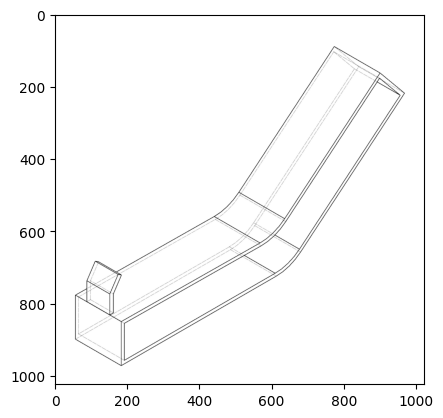

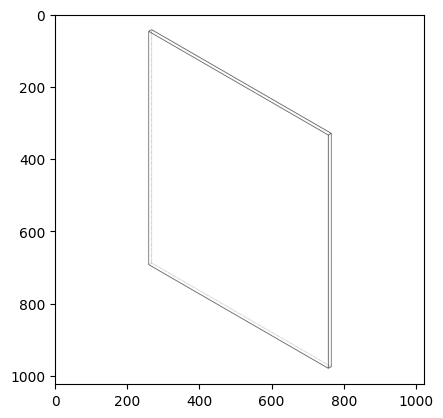

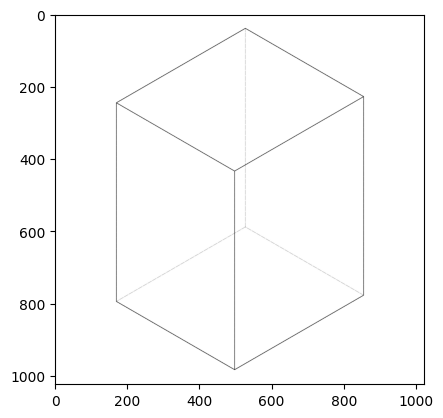

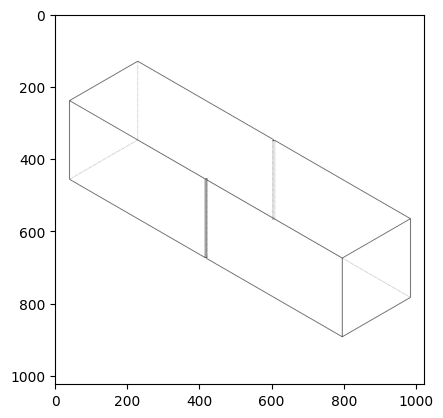

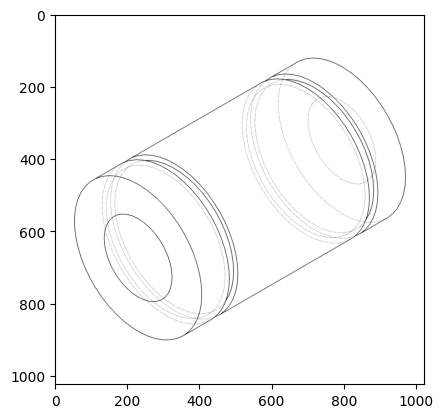

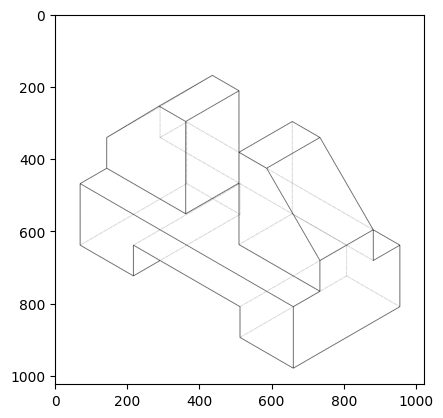

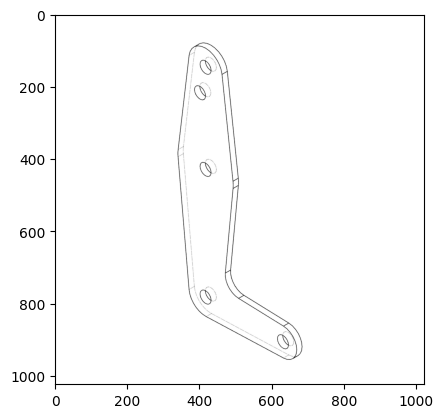

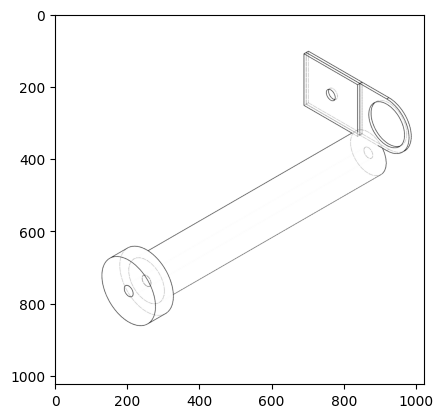

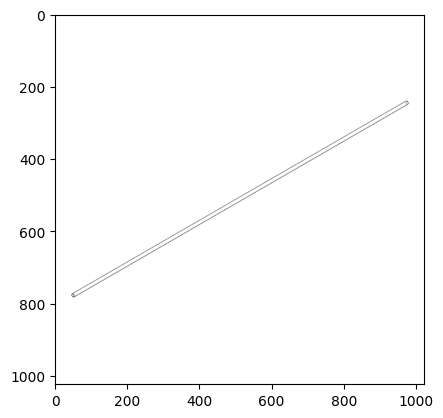

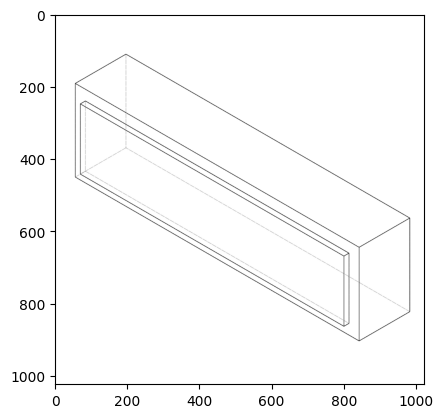

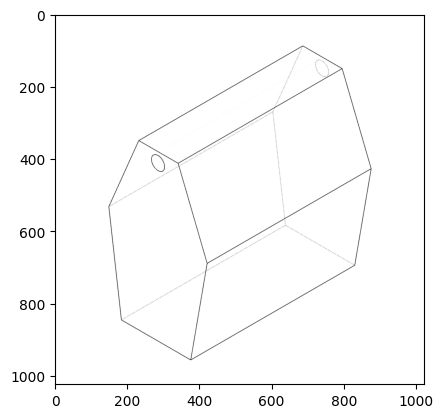

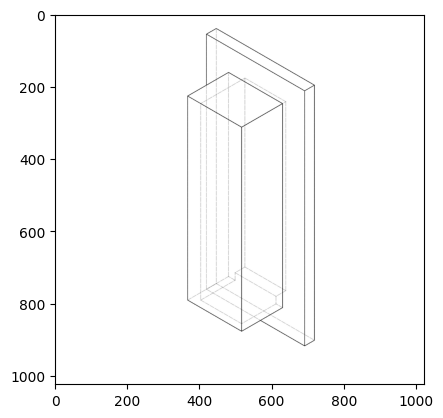

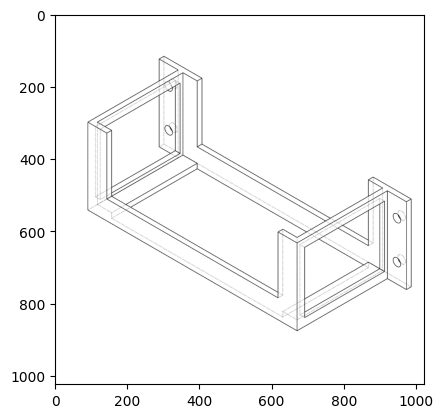

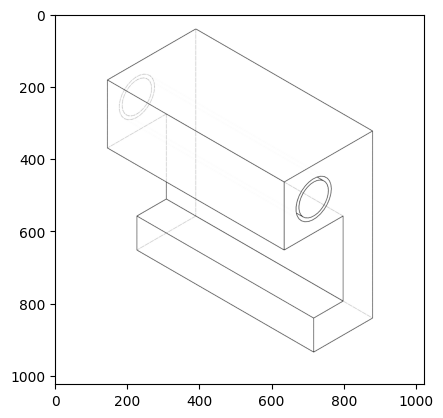

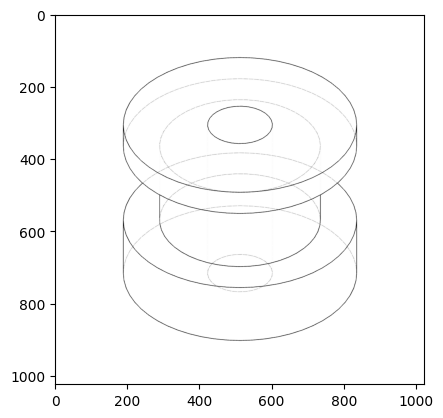

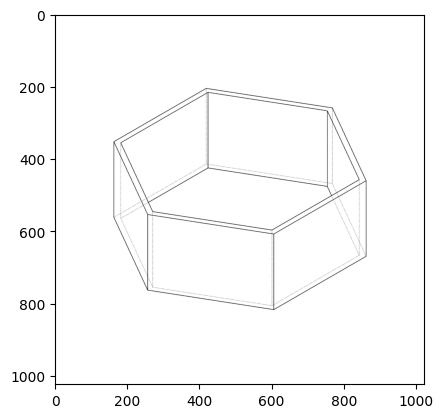

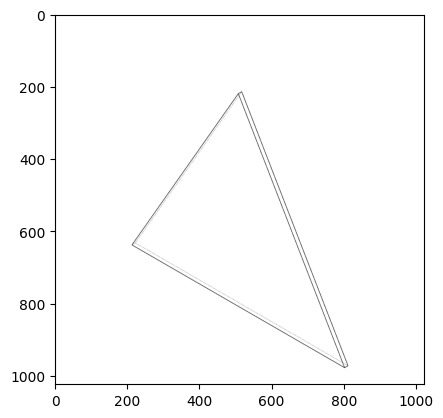

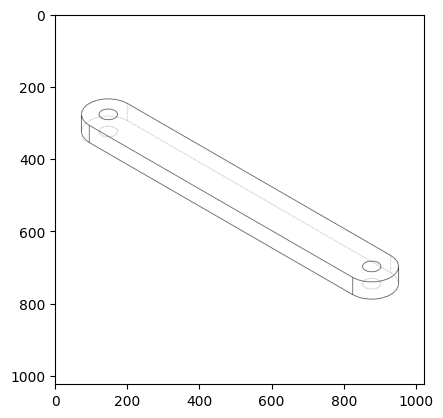

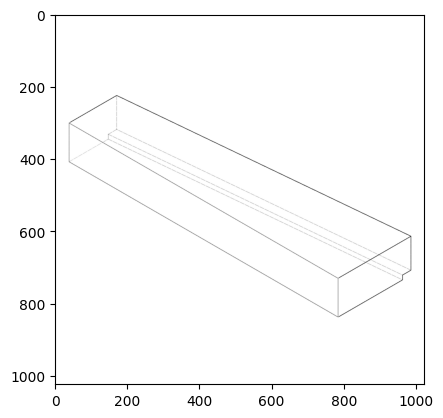

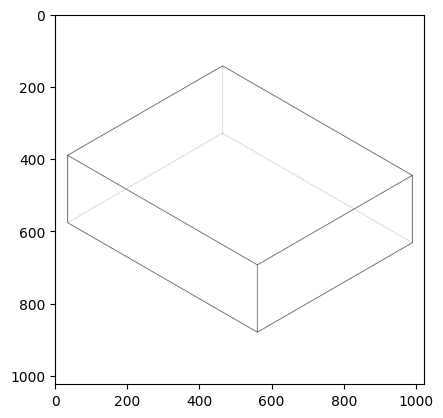

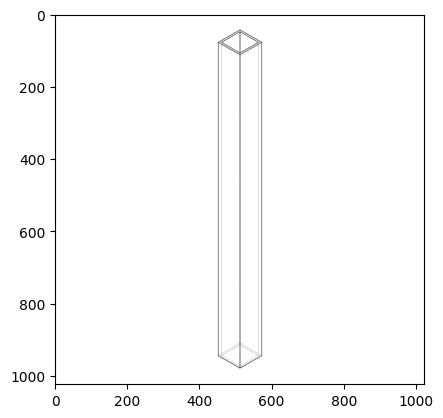

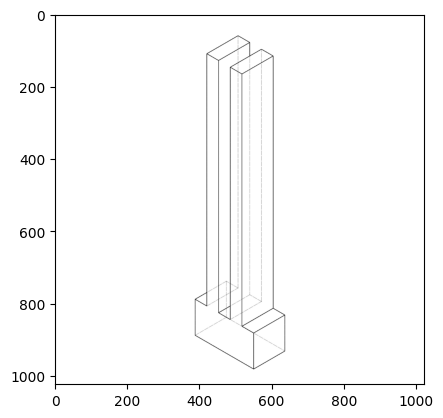

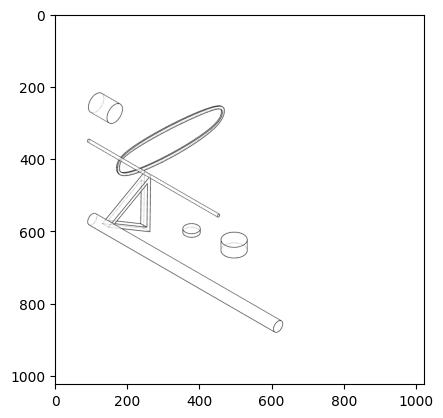

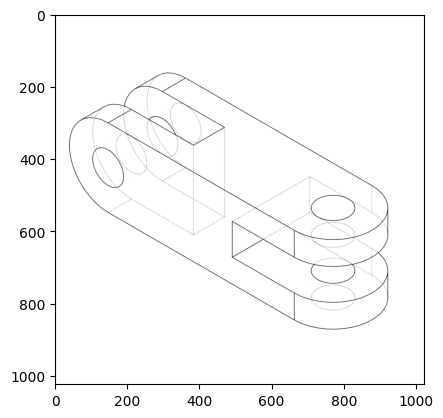

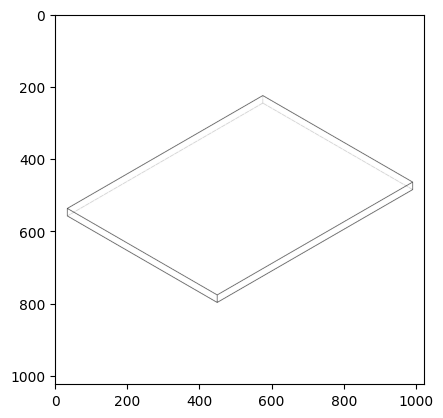

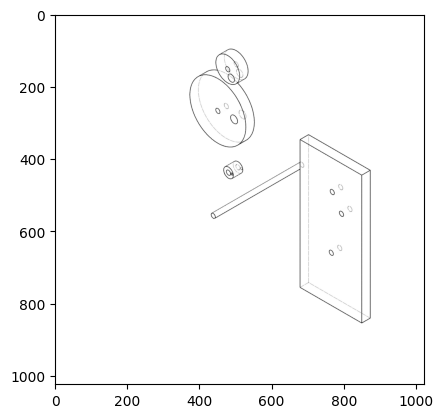

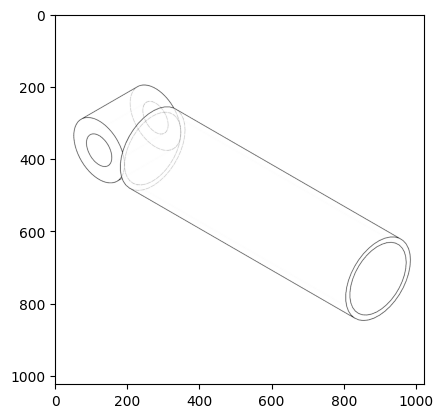

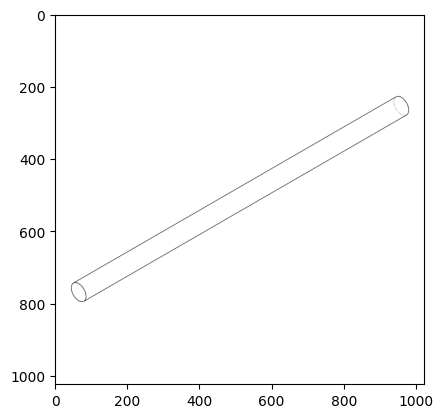

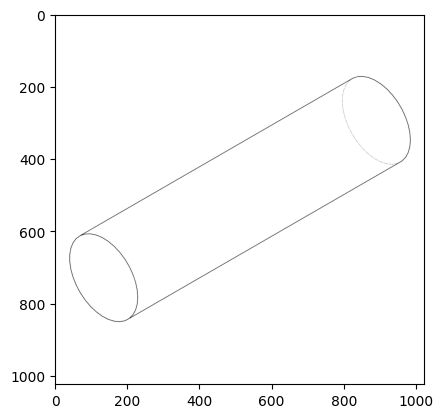

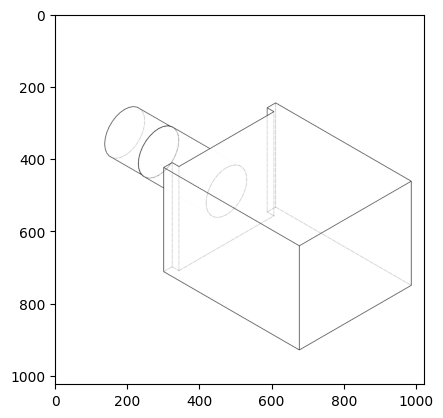

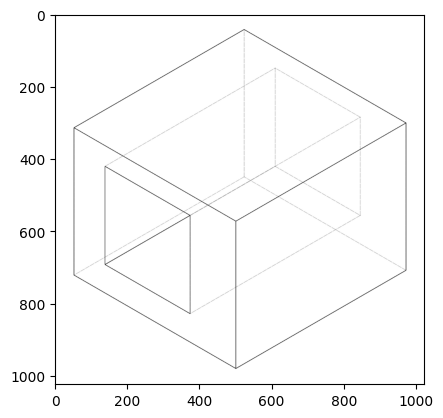

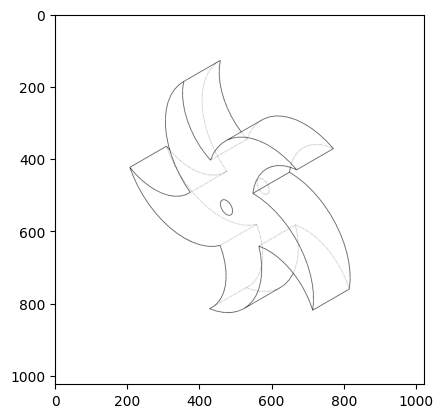

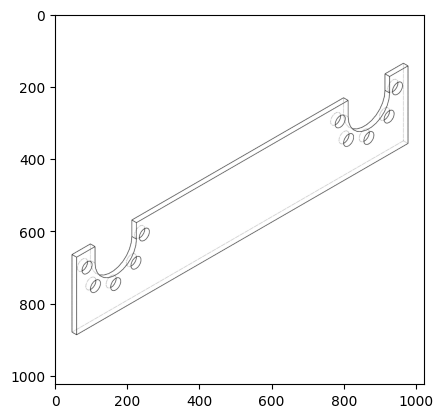

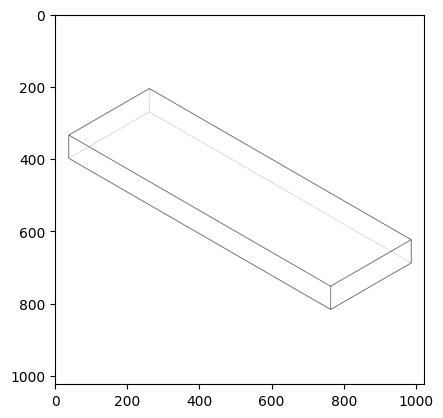

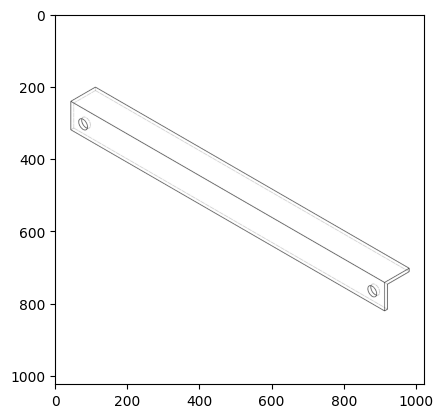

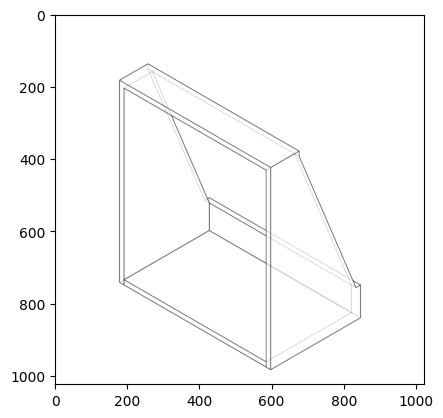

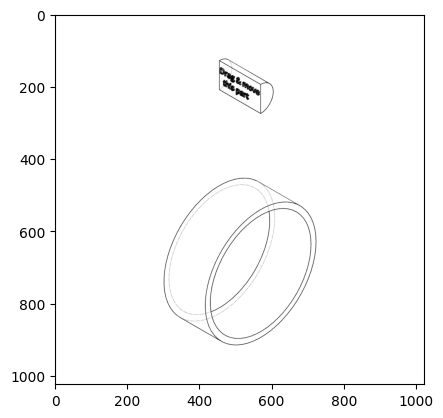

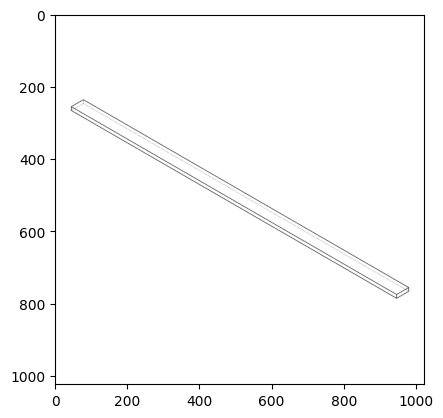

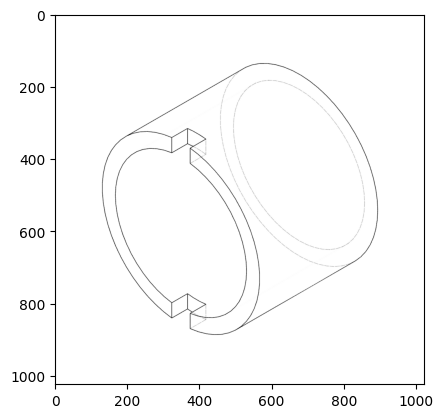

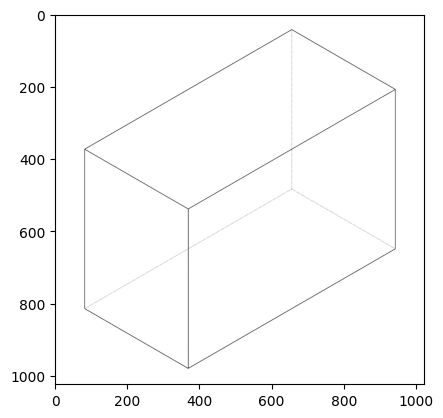

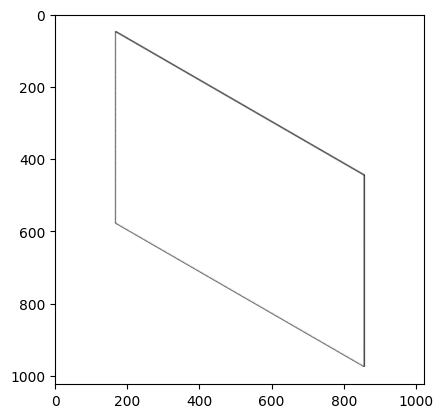

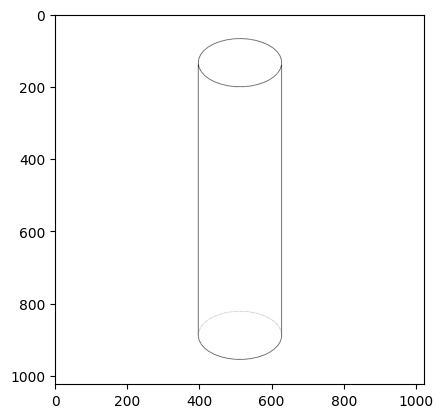

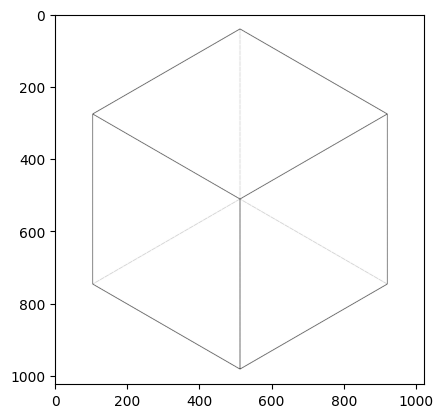

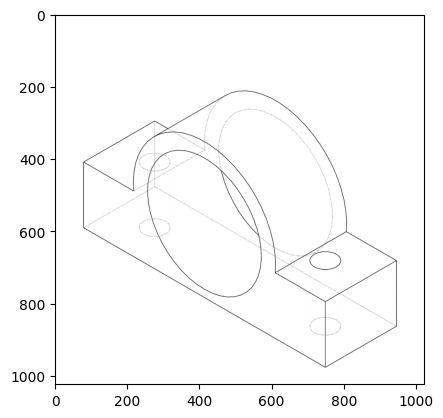

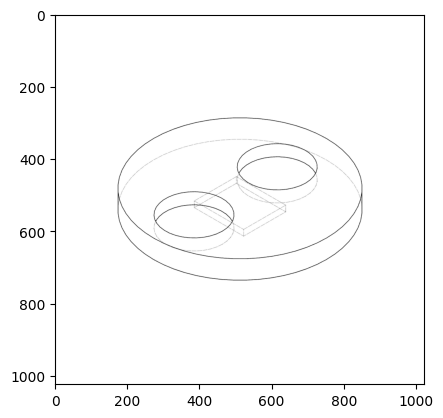

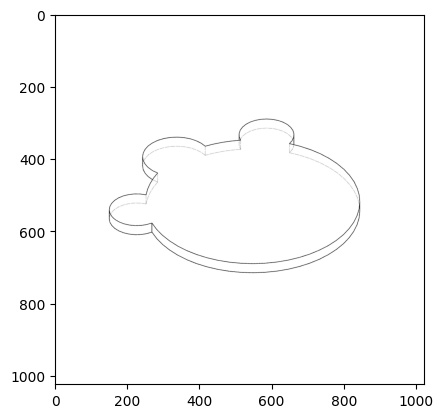

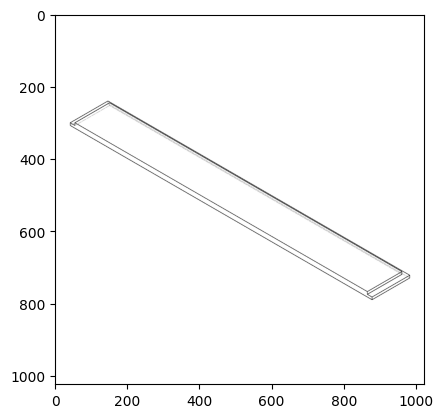

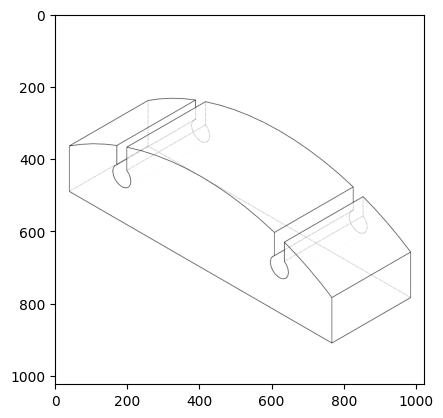

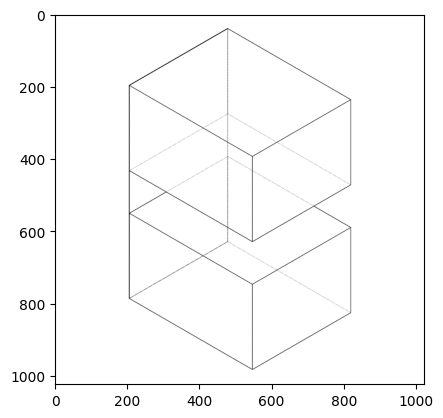

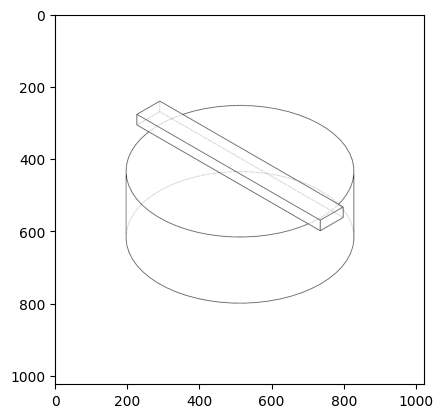

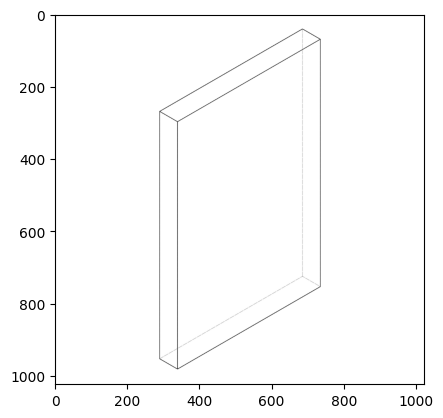

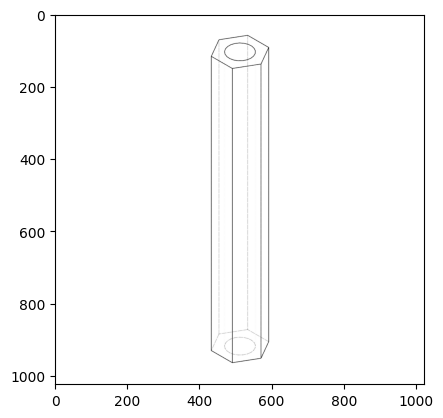

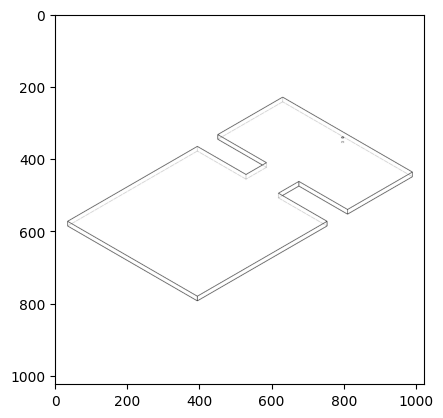

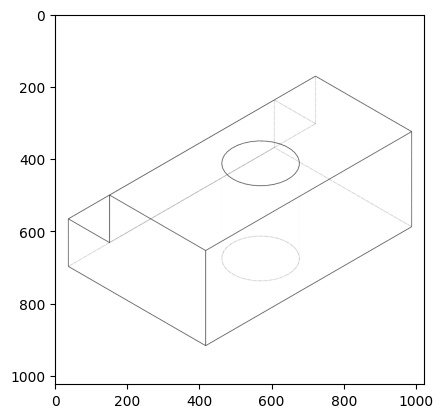

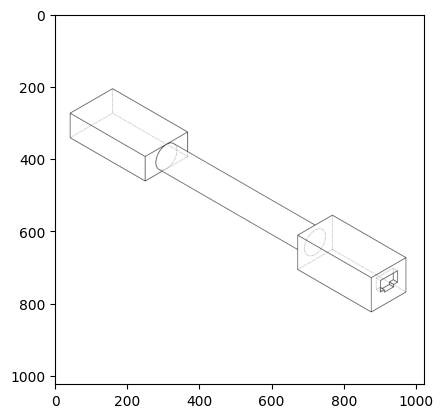

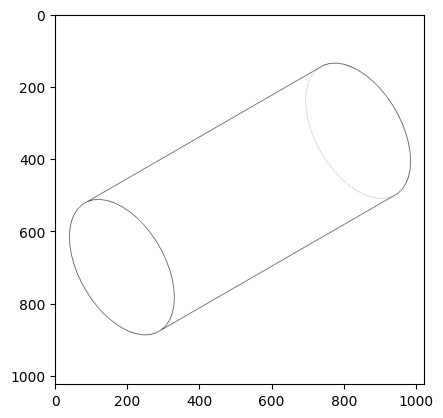

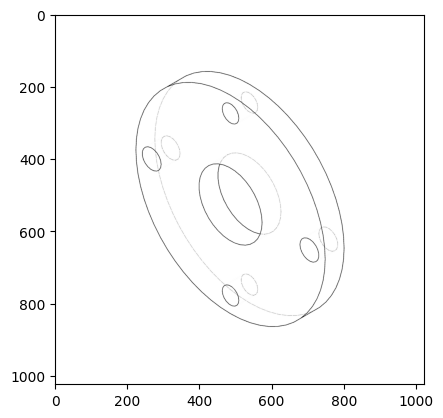

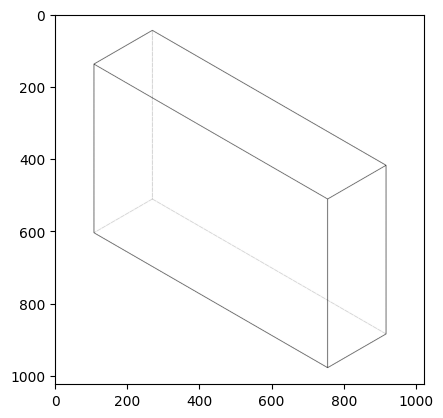

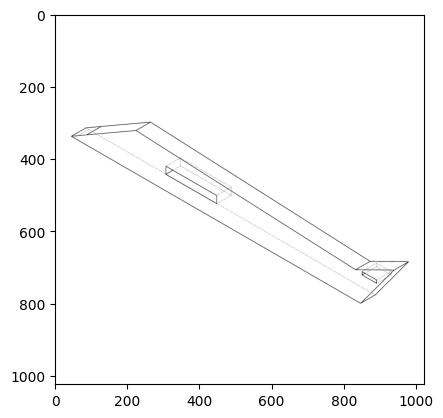

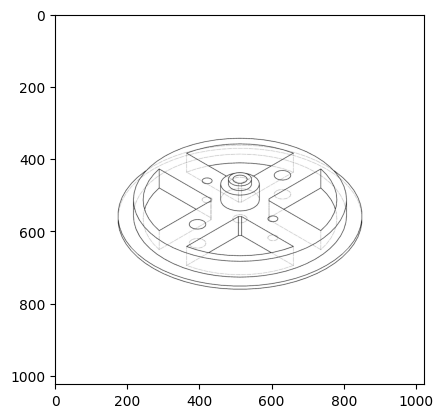

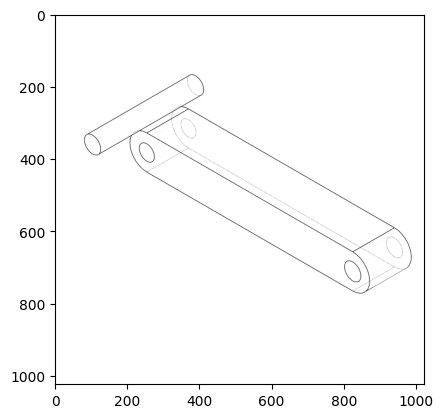

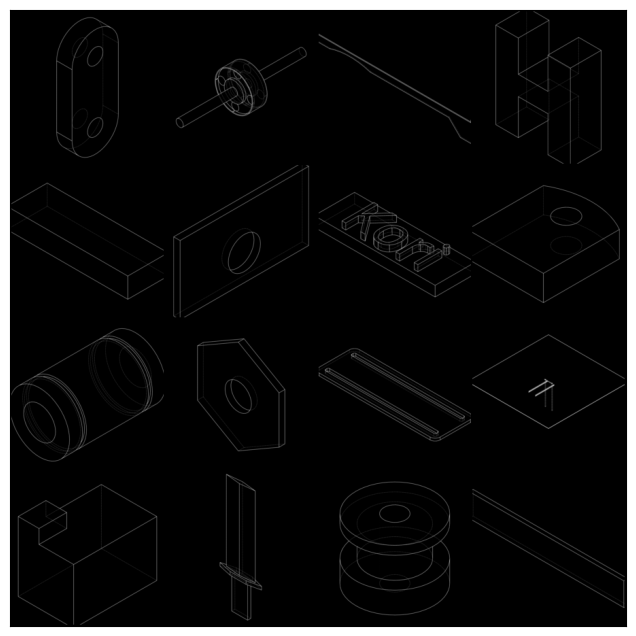

In [ ]:
batch_size = 64
train_dl = DataLoader(traindata, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(testdata, 1, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(valdata, batch_size, shuffle=True, num_workers=2, pin_memory=True)

def show_images(images, nmax=16):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=4).permute(1, 2, 0))

def show_batch(dl, nmax=16):
    for images in dl:
        show_images(images[0], nmax)
        break

show_batch(train_dl)

# Load Model

#### Get VGG Model Sequence and Maybe Weights





In [ ]:
# read in VGG model weights
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)

# freeze the existing conv and fc layers
for param in model.features.parameters():
    param.requires_grad = False

n_inputs = model.classifier[6].in_features # 4096 inputs into last fc layer of VGG pretrained
last_layer = nn.Linear(n_inputs, 2048) # change last fc layer num_outputs to learn layer 
fc_layers = nn.Sequential(
    last_layer,
    nn.BatchNorm1d(2048),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(512, 512) # dim = 256 feeds into the decoder
)
model.classifier[6] = fc_layers # append new layers to existing VGG11 model

# ensure new fc layers ar unfrozen to learn parameters
for param in model.classifier[6].parameters():
    param.requires_grad = True

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:05<00:00, 89.1MB/s]


#### Load DeepCAD Weights to acceept the latent vector (dimensionality = 256) from the last linear layer in the model dclareed above

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(input_dim, num_heads)
        self.norm1 = nn.LayerNorm(input_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x):
        attn_out, _ = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout1(attn_out))
        ff_out = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_out))
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, dropout, num_commands):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerBlock(input_dim, hidden_dim, num_heads, dropout)
            for _ in range(num_layers)
        ])
        self.command_type = nn.Linear(input_dim, num_commands * 60)
        self.command_params = nn.Linear(input_dim, 16 * 257 * 60)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        command_type = self.command_type(x).view(-1, 60, 6)
        command_params = self.command_params(x).view(-1, 60, 16, 257)
        return command_type, command_params

# Define the model using the specified configuration
input_dim = 512
hidden_dim = 512
num_heads = 8
num_layers = 4
dropout = 0.1
num_commands = 6
decoder = TransformerDecoder(input_dim, hidden_dim, num_heads, num_layers, dropout, num_commands)




# Create Combined Model

In [ ]:
combo_model = nn.Sequential(*(list(model.children()) + list(decoder.children())))

##### Test VGG on a Single img

In [ ]:

# if torch.cuda.is_available():
#   input_batch = train_dl.to('cuda')
#   model.to('cuda')

# with torch.no_grad():
#   output = model(input_batch)

# print(output.size())


# Specify Loss and Optimizer

In [ ]:

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train

In [ ]:
def train_model(model, optimizer, epochs=1, print_every=10):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y_1, y_2) in enumerate(train_dl):
            model.train()  # put model to training mode
            x = x.to(device=device)  # move to device, e.g. GPU
            y_1 = y_1.to(device=device, dtype=torch.float)
            y_2 = y_2.to(device=device, dtype=torch.float)

            
            scores = model(x) # gives (1, 512) input for transformr decoder
            command_type, command_params = decoder(scores) # decoder output

            command_type_loss = F.cross_entropy(command_type, y_1)
            command_params_loss = 0
            for i in range(len(y_2)):
              command_params_loss += F.cross_entropy(command_params[i], y_2[i])

            
            loss = command_type_loss/10 + command_params_loss

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                #check_accuracy_part34(loader_val, model)
                print()
    return model, decoder

In [ ]:
baseline = train_model(model, optimizer, epochs=10, print_every=20)
torch.save(baseline[1].state_dict(), 'decoder.pth')

KeyboardInterrupt: ignored